# MSCI 598: Custom Project
## Medical Abstract Classification


In [1]:
import pandas as pd
import numpy as np 
import random
import math
import tensorflow as tf
print(tf.__version__)
import os
import re
import shutil
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow_estimator.python.estimator.canned.dnn import dnn_logit_fn_builder

import tensorflow_hub as hub
import tensorflow_text as text

2.8.0


In [2]:
print(tf.test.gpu_device_name())
tf.config.experimental.list_physical_devices('GPU')

#shutil.rmtree('C:/Users/Tia/AppData/Local/Temp/tfhub_modules/f5e3261f68125d7957e226012645cbc2b1c16575')

[]

In [3]:
# SOURCE for preprocessing functions: 
# Abstract Segmentation NLP notebook (https://www.kaggle.com/anshulmehtakaggl/abstract-segmentation-nlp)

# Creating a function to read the txt Files
# This function returns all the lines in the txt file as a list
def get_lines(filename):
    with open(filename,"r") as f:
        return f.readlines()

# Creating a function to read the txt Files
# This function returns all the lines in the txt file as a list
def get_lines(filename):
    with open(filename,"r") as f:
        return f.readlines()

#Preprocessing Functions
# Returns a list of dictionaries of abstract's lines
# Dict Format --> {'TARGET':'Background/Results/Objetive/Concludion','Text':'The actual statement'}
def preprocess_data(filename):
    input_lines=get_lines(filename)
    #This will be used to separte the abstracts from  one another using String mets
    abstract_lines=""
    # Empty list of abstracts        
    abstract_samples=[]
    for line in input_lines:
        # Check for a new abstract
        if line.startswith("###"):
            abstract_id=line
            # And since we are in a new abstract we will Reset the abstract_lines
            abstract_lines=""
        # Check for a new line \n escape seq
        elif line.isspace():
            # Split the Lines of the abstract and will return a list of one abstract
            abstract_line_split=abstract_lines.splitlines()
            # Now we have to iterate through this singular abstract
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                #  Enumerate() method adds a counter to an iterable and returns it in a form of enumerating object.
                # Create a empty Dict per line
                line_data={}
                # Split on the tab \t esc seq
                target_text_split=abstract_line.split("\t")
                # Get the Label of the sentence as the Label
                line_data["target"]=target_text_split[0]
                # Get the Text of the Lien as the Text Key
                line_data["text"]=target_text_split[1].lower()
                # Also adding the Line Nnumber as it will also aid the model
                line_data["line_number"]=abstract_line_number
                # Number of Lines in that particular abstract
                line_data["total_lines"]=len(abstract_line_split)-1
                # Now we have to append them to the absract_samples list
                abstract_samples.append(line_data)
        # So if both the cases are not there then the line is a labelled sentence
        else:
            abstract_lines+=line
    return abstract_samples


In [4]:
# Reading in and preprocessing data
data_dir = "D:/med_abstracts/20k_abstracts_numbers_with_@/"
filenames=[data_dir + filename for filename in os.listdir(data_dir)]
print(filenames)

train_samples=preprocess_data(data_dir+"train.txt")
val_samples=preprocess_data(data_dir+"dev.txt")
test_samples=preprocess_data(data_dir+"test.txt")        


['D:/med_abstracts/20k_abstracts_numbers_with_@/dev.txt', 'D:/med_abstracts/20k_abstracts_numbers_with_@/test.txt', 'D:/med_abstracts/20k_abstracts_numbers_with_@/train.txt']


In [5]:
# Converting data to df
train_df=pd.DataFrame(train_samples)
test_df=pd.DataFrame(test_samples)
val_df=pd.DataFrame(val_samples)

# Data distribution
train_df.target.value_counts()

# Isolating the sentences
train_sentences=train_df["text"].tolist()
test_sentences=test_df["text"].tolist()
val_sentences=val_df["text"].tolist()

In [6]:
# Turning the target Labels into Numeric Data
# We have 5 main labels -> Background, Objective,Methods, Results, Conclusion
# We'll encode them both 1HEC and Simple Numerical

# Tensorflow is incompatible with sparse matrices
one_hot_encoder=OneHotEncoder(sparse=False)
# You should reshape your X to be a 2D array not 1D array. Fitting a model requires requires a 2D array. i.e (n_samples, n_features)
train_labels_one_hot=one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot=one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot=one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1,1))
train_labels_one_hot,val_labels_one_hot,test_labels_one_hot

le=LabelEncoder()
train_labels_encoded=le.fit_transform(train_df["target"])
test_labels_encoded=le.fit_transform(test_df["target"])
val_labels_encoded=le.fit_transform(val_df["target"])

# Retieving classes 
num_classes=len(le.classes_)
class_names=le.classes_
num_classes,class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [7]:
# Vectorize the text and then create Embeddings

# How long is each sentence on average
sent_lens=[len(sentence.split()) for sentence in train_sentences]
avg_sent_lens=np.mean(sent_lens)
avg_sent_lens
# sent_lens
#  So we will need Padding and Truncating as the input shapes must be maintained

# Calculate the percentile of length of sentences
output_seq_len=int(np.percentile(sent_lens,95))
output_seq_len
# So 95% sentences are in length of 55

# Creating a text Vectorization Layer
# Mapping our text from words to Numbers
# An embedding is a relatively low-dimensional space into which you can translate high-dimensional vectors. 
# Vocabulary size in the Research Paper is 68000
max_tokens=68000

text_vectorizer=TextVectorization(max_tokens=max_tokens,output_sequence_length=output_seq_len)

# Adapt the Text Vectorizer to the Training Data
# We have to adapt it to only the training data so that val and test data are not seen
# Later it can be fitted to the two latter
text_vectorizer.adapt(train_sentences)

In [8]:
# Finding out how many words are there  in the training vocabulary and which are  most common
# Also text vectorizer works pretty straightforwardly, 1 to most common word, 2 to 2nd most common word and so on
train_vocab=text_vectorizer.get_vocabulary()
# Size of Vocab
print(len(train_vocab))
# 5 Most Common Words in the Vocab
print(train_vocab[:5])
# Least common 5 words in the vocab
print(train_vocab[-5:])

# Get the config of our Text Vectorizer
text_vectorizer.get_config()

64841
['', '[UNK]', 'the', 'and', 'of']
['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

In [9]:
# Create an Embedding Layer
# More output dims , more emmbedding, more parameters to train
# Masking the 0 considering them as padding
token_embed=layers.Embedding(input_dim=len(train_vocab),output_dim=128,mask_zero=True,name="token_embedding")

In [10]:
# Creating a Fast Loadinng Dataset with tf data API
# https://www.tensorflow.org/guide/data_performance
# https://www.tensorflow.org/guide/data
# Turn our data into Tensorflow datasets
train_dataset=tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
val_dataset=tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset=tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))
train_dataset
# <TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>
# Which indicates one Text Sample in first tuple, next tuple is (0,0,0,0,1) -> 1hc 

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [11]:
# Pre fetching the data and making them into batches
# Pre fetching reduces the Preparation time of Data taken by CPU
# Pref-fetching in a Multi-threaded way Reduces time and Increases the amount of data as all cores can be utilized to Prepare the Data
# The GPU will do the Computation
train_dataset=train_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset=val_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset=test_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)
train_dataset
# Run the Previous steps as well this otherwie the Shapes will not be fixed
# PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

# Small BERT

In [13]:
# PubMed model
tfhub_handle_encoder = 'https://tfhub.dev/google/experts/bert/pubmed/2'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

# Base model
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

# Small model (L=2, H-128)
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'


bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [14]:
# Sequence length from data notebook
SEQ_LENGTH = 128
def make_bert_preprocess_model(sentence_features, seq_length=128):
    """Returns Model mapping string features to BERT inputs.

    Args:
    sentence_features: a list with the names of string-valued features.
    seq_length: an integer that defines the sequence length of BERT inputs.

    Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
    """

    input_segments = [
      tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
      for ft in sentence_features]

    # Tokenize the text to word pieces.
    bert_preprocess = hub.load(tfhub_handle_preprocess)
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
    segments = [tokenizer(s) for s in input_segments]

    # Optional: Trim segments in a smart way to fit seq_length.
    # Simple cases (like this example) can skip this step and let
    # the next step apply a default truncation to approximately equal lengths.
    truncated_segments = segments

    # Pack inputs. The details (start/end token ids, dict of output tensors)
    # are model-dependent, so this gets loaded from the SavedModel.
    packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                          arguments=dict(seq_length=seq_length),
                          name='packer')
    model_inputs = packer(truncated_segments)
    return tf.keras.Model(input_segments, model_inputs)

In [15]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test) 

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [16]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Pooled Outputs Shape:(1, 128)
Pooled Outputs Values:[-0.9999946   0.14341967 -0.9989779   0.9951447  -0.9997457   0.91312915
 -0.996158   -0.970975    0.09740018  0.01907056 -0.8488174  -0.09385558]
Sequence Outputs Shape:(1, 128, 128)
Sequence Outputs Values:[[-0.43723777 -1.0138294  -2.3744736  ... -0.75897074 -2.0910308
  -0.25810003]
 [-1.3369725  -0.36880285  0.57868814 ... -2.1810155  -1.7530916
  -0.09555084]
 [-1.0607057  -0.30371094  0.34461197 ... -1.2898581  -1.9519899
  -0.1223034 ]
 ...
 [-0.8602276  -0.54406136  0.6583733  ... -1.4765685  -1.7518615
   1.1197373 ]
 [-0.46869028 -0.57152355  0.6725654  ... -1.7302345  -1.9740773
   0.9747925 ]
 [ 0.02036603 -0.7551192   0.5948237  ... -1.9656781  -1.905142
   0.4897015 ]]


In [17]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    a,b = encoder.get_weights()[0].shape
    
    weights_list = []
    for weight in encoder.get_weights():

        if len(weight.shape) > 2:
            rand_weight = np.random.randn(weight.shape[0], weight.shape[1], weight.shape[2])
        elif len(weight.shape) > 1:
            rand_weight = np.random.randn(weight.shape[0], weight.shape[1])
        elif len(weight.shape) > 0:
            rand_weight = np.random.randn(weight.shape[0])
        else:
            rand_weight = []
        
        for rnd in rand_weight:
            rnd = random.gauss(0, 1/math.sqrt(weight.shape[0]))
        weights_list.append(rand_weight)
    
    weights_list[39] = encoder.get_weights()[39]

    encoder.set_weights(weights_list)
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    #net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    net=tf.keras.layers.Dense(num_classes,activation="softmax")(net)
    return tf.keras.Model(text_input, net)


classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.5036261  0.54588753 0.6568271  0.5065808  0.53143746]], shape=(1, 5), dtype=float32)


In [18]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "D:/med_abstracts/models/smallbert/"
checkpoint_dir = os.path.dirname(checkpoint_path)

#batch_size = 32
# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    save_freq='epoch')


# Save the weights using the `checkpoint_path` format
#classifier_model.load_weights("training/cp-0001.ckpt.index")
classifier_model.save_weights(checkpoint_path.format(epoch=0))


epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5

classifier_model.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(),metrics=[tf.metrics.Accuracy(), tf.metrics.CategoricalAccuracy(), tf.metrics.CategoricalCrossentropy()])

In [19]:
batch_size = 32
seed = 42
epochs = 5

print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_dataset,
                               validation_data=val_dataset,
                               callbacks=[cp_callback],
                               #steps_per_epoch = int(0.1*len(train_sentences)//batch_size),
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Epoch 1/5
5627/5627 [==============================] - ETA: 0s - loss: 1.5056 - accuracy: 0.0000e+00 - categorical_accuracy: 0.3249 - categorical_crossentropy: 1.5056

INFO:tensorflow:Assets written to: D:/med_abstracts/models/smallbert\assets


INFO:tensorflow:Assets written to: D:/med_abstracts/models/smallbert\assets


5627/5627 [==============================] - 3165s 561ms/step - loss: 1.5056 - accuracy: 0.0000e+00 - categorical_accuracy: 0.3249 - categorical_crossentropy: 1.5056 - val_loss: 1.4657 - val_accuracy: 0.0000e+00 - val_categorical_accuracy: 0.3664 - val_categorical_crossentropy: 1.4657
Epoch 2/5
5627/5627 [==============================] - ETA: 0s - loss: 1.4025 - accuracy: 0.0000e+00 - categorical_accuracy: 0.3741 - categorical_crossentropy: 1.4025

INFO:tensorflow:Assets written to: D:/med_abstracts/models/smallbert\assets


INFO:tensorflow:Assets written to: D:/med_abstracts/models/smallbert\assets


5627/5627 [==============================] - 2814s 500ms/step - loss: 1.4025 - accuracy: 0.0000e+00 - categorical_accuracy: 0.3741 - categorical_crossentropy: 1.4025 - val_loss: 1.3636 - val_accuracy: 0.0000e+00 - val_categorical_accuracy: 0.4020 - val_categorical_crossentropy: 1.3636
Epoch 3/5
5627/5627 [==============================] - ETA: 0s - loss: 1.3794 - accuracy: 0.0000e+00 - categorical_accuracy: 0.3853 - categorical_crossentropy: 1.3794

INFO:tensorflow:Assets written to: D:/med_abstracts/models/smallbert\assets


INFO:tensorflow:Assets written to: D:/med_abstracts/models/smallbert\assets


5627/5627 [==============================] - 2596s 461ms/step - loss: 1.3794 - accuracy: 0.0000e+00 - categorical_accuracy: 0.3853 - categorical_crossentropy: 1.3794 - val_loss: 1.2976 - val_accuracy: 0.0000e+00 - val_categorical_accuracy: 0.4502 - val_categorical_crossentropy: 1.2976
Epoch 4/5
5627/5627 [==============================] - ETA: 0s - loss: 1.3027 - accuracy: 0.0000e+00 - categorical_accuracy: 0.4245 - categorical_crossentropy: 1.3027

INFO:tensorflow:Assets written to: D:/med_abstracts/models/smallbert\assets


INFO:tensorflow:Assets written to: D:/med_abstracts/models/smallbert\assets


5627/5627 [==============================] - 2623s 466ms/step - loss: 1.3027 - accuracy: 0.0000e+00 - categorical_accuracy: 0.4245 - categorical_crossentropy: 1.3027 - val_loss: 1.2420 - val_accuracy: 0.0000e+00 - val_categorical_accuracy: 0.4519 - val_categorical_crossentropy: 1.2420
Epoch 5/5
5627/5627 [==============================] - ETA: 0s - loss: 1.2422 - accuracy: 0.0000e+00 - categorical_accuracy: 0.4544 - categorical_crossentropy: 1.2422

INFO:tensorflow:Assets written to: D:/med_abstracts/models/smallbert\assets


INFO:tensorflow:Assets written to: D:/med_abstracts/models/smallbert\assets


5627/5627 [==============================] - 2909s 517ms/step - loss: 1.2422 - accuracy: 0.0000e+00 - categorical_accuracy: 0.4544 - categorical_crossentropy: 1.2422 - val_loss: 1.1523 - val_accuracy: 0.0000e+00 - val_categorical_accuracy: 0.5053 - val_categorical_crossentropy: 1.1523


In [20]:
#model.save('models/small_BERT_model')
classifier_model.save('D:/med_abstracts/models/smallbert/small_BERT_model')

INFO:tensorflow:Assets written to: D:/med_abstracts/models/smallbert/small_BERT_model\assets


INFO:tensorflow:Assets written to: D:/med_abstracts/models/smallbert/small_BERT_model\assets


In [21]:
results = classifier_model.evaluate(test_dataset, batch_size=128)

942/942 [==============================] - 170s 180ms/step - loss: 1.1595 - accuracy: 0.0000e+00 - categorical_accuracy: 0.5047 - categorical_crossentropy: 1.1595


In [22]:
predictions = classifier_model.predict(test_dataset)

[1 1 2 ... 2 2 2]
[0 4 4 ... 4 4 1]
Classification Report:
              precision    recall  f1-score   support

  BACKGROUND     0.3659    0.1281    0.1898      3621
 CONCLUSIONS     0.3536    0.4907    0.4110      4571
     METHODS     0.4670    0.8434    0.6011      9897
   OBJECTIVE     0.8109    0.3180    0.4569      2333
     RESULTS     0.9138    0.3513    0.5075      9713

    accuracy                         0.5047     30135
   macro avg     0.5822    0.4263    0.4333     30135
weighted avg     0.6083    0.5047    0.4815     30135



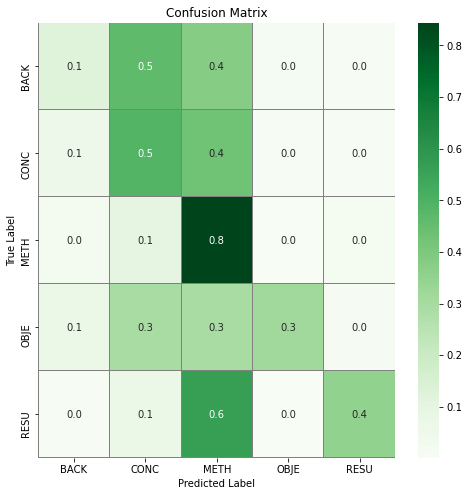

In [23]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

y_test = test_labels_one_hot

word_labels = np.unique(train_df["target"])
word_labels_short = [word_labels[i][:4] for i in np.arange(len(word_labels))]

Y_pred_classes = np.argmax(predictions,axis = 1) 
# Convert validation observations to one hot vectors
print(Y_pred_classes)
Y_true = np.argmax(y_test,axis = 1)
print(Y_true)

print('Classification Report:')
print(classification_report(Y_true, Y_pred_classes, labels=[0,1,2,3,4], target_names=word_labels, digits=4))

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes, normalize='true') 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
ax.yaxis.set_ticklabels(word_labels_short)
ax.xaxis.set_ticklabels(word_labels_short)
plt.show()


In [47]:
reloaded_model = tf.saved_model.load('D:/med_abstracts/models/smallbert/small_BERT_model')

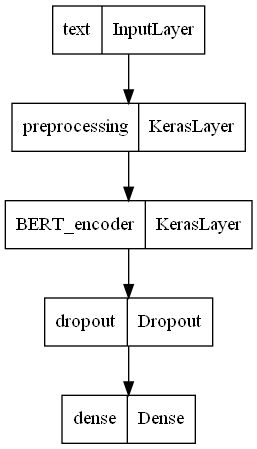

In [18]:
tf.keras.utils.plot_model(classifier_model)